# Stack Overflow Technology Embedding and Matching

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Ensure required NLTK resources are available.
# nltk.download('punkt')
# nltk.download('stopwords')

class ConceptMatcher:
    def __init__(
        self,
        csv_path="../data/processed/technologies_with_abbreviations.csv",  # Updated path to new CSV with abbreviations
        columns=None,
        model_name="all-mpnet-base-v2",
        similarity_threshold_graph=0.7,
        ngram_threshold=0.5,
        filter_similarity_threshold=0.85
    ):
        if columns is None:
            columns = [
                "LanguageHaveWorkedWith", "DatabaseHaveWorkedWith", "PlatformHaveWorkedWith",
                "WebframeHaveWorkedWith", "EmbeddedHaveWorkedWith", "MiscTechHaveWorkedWith",
                "ToolsTechHaveWorkedWith"
            ]
        self.csv_path = csv_path
        self.columns = columns
        self.model_name = model_name
        self.similarity_threshold_graph = similarity_threshold_graph
        self.ngram_threshold = ngram_threshold
        self.filter_similarity_threshold = filter_similarity_threshold

        # Initialize NLTK stop words and custom filter words.
        self.stop_words = set(stopwords.words('english'))
        self.custom_filter_words = {
            'additionally', 'also', 'furthermore', 'moreover', 'including', 'like', 'career', 'etc'
        }

        # Initialize the SentenceTransformer model.
        self.model = SentenceTransformer(self.model_name)

        # Placeholders for later processing.
        self.tech_data = None          # DataFrame to store technology names and abbreviations
        self.stack_concepts = []       # List of concept dictionaries.
        self.concept_embeddings = None # Numpy array of concept embeddings.
        self.candidate_phrases = []    # Candidate n‑gram phrases from input text.
        self.candidate_embeddings = None  # Numpy array of candidate embeddings.
        self.recognized_candidates_ngram = []  # Matched candidates with similarity scores.
        self.filtered_by_concept = {}     # Final grouped output after global filtering.
        self.graph = None                 # Optional similarity graph.

    def clean_text(self, text):
        """
        Lowercase the text and remove punctuation except for hyphens and parentheses.
        """
        # Preserve '-' and parentheses by removing other punctuation.
        punctuation_to_remove = "".join(ch for ch in string.punctuation if ch not in "-()")
        text = text.lower().translate(str.maketrans("", "", punctuation_to_remove))
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in self.stop_words]
        return " ".join(tokens)

    def is_meaningful(self, phrase):
        tokens = [t.lower() for t in word_tokenize(phrase) if t.isalpha()]
        if not tokens:
            return False
        if any(token in self.custom_filter_words for token in tokens):
            return False
        if len(tokens) == 1 and tokens[0] in self.stop_words:
            return False
        if tokens and sum(1 for t in tokens if t in self.stop_words) / len(tokens) > 0.5:
            return False
        return True

    def load_concepts(self):
        # Load the technology data with abbreviations
        self.tech_data = pd.read_csv(self.csv_path)
        print(f"Loaded technologies data with {len(self.tech_data)} entries")
        
        # Create concepts from both technology names and their abbreviations
        self.stack_concepts = []
        
        # Add technology names first
        for _, row in self.tech_data.iterrows():
            tech_name = row['Technology']
            self.stack_concepts.append({"name": tech_name, "type": "Technology", "original": tech_name})
        
        # Add abbreviations if they exist
        for _, row in self.tech_data.iterrows():
            if pd.notna(row['abrv']) and row['abrv'].strip():  # Check if abbreviation exists and is not empty
                tech_name = row['Technology']
                abbr = row['abrv']
                self.stack_concepts.append({"name": abbr, "type": "Abbreviation", "original": tech_name})
        
        print(f"Total StackOverflow Concepts (including abbreviations): {len(self.stack_concepts)}")

    def generate_concept_embeddings(self, save_embeddings=True, load_if_exists=True):
        """
        Generate embeddings for all technology concepts or load existing ones if available.
        
        Parameters:
        - save_embeddings: Whether to save newly generated embeddings
        - load_if_exists: Whether to try loading existing embeddings first
        """
        filename = f"stack_concept_embeddings_{self.model_name.replace('/', '_')}.npy"
        
        # Try to load existing embeddings if requested
        if load_if_exists:
            try:
                self.concept_embeddings = np.load(filename)
                print(f"Loaded existing concept embeddings from {filename}")
                return
            except FileNotFoundError:
                print(f"No existing embeddings found at {filename}, generating new ones...")
        
        # Generate new embeddings
        concept_texts = [concept["name"] for concept in self.stack_concepts]
        self.concept_embeddings = self.model.encode(concept_texts, convert_to_numpy=True)
        
        if save_embeddings:
            np.save(filename, self.concept_embeddings)
            print(f"Concept embeddings saved to {filename}")

    def build_similarity_graph(self):
        self.graph = nx.Graph()
        concept_texts = [concept["name"] for concept in self.stack_concepts]
        for concept in self.stack_concepts:
            self.graph.add_node(concept["name"], category=concept["type"], original=concept.get("original", concept["name"]))
        sim_matrix = cosine_similarity(self.concept_embeddings)
        for i in range(len(concept_texts)):
            for j in range(i + 1, len(concept_texts)):
                if sim_matrix[i][j] >= self.similarity_threshold_graph:
                    self.graph.add_edge(concept_texts[i], concept_texts[j], weight=sim_matrix[i][j])
        print(f"Graph contains {len(self.graph.nodes)} nodes and {len(self.graph.edges)} edges.")

    def prepare_candidate_phrases(self, long_text):
        cleaned_full_text = self.clean_text(long_text)
        tokens_clean = word_tokenize(cleaned_full_text)
        candidate_phrases = []
        for n in [3, 2, 1]:
            for gram in ngrams(tokens_clean, n):
                phrase = " ".join(gram)
                if phrase.strip() and self.is_meaningful(phrase):
                    candidate_phrases.append(phrase)
        self.candidate_phrases = list(set(candidate_phrases))
        print(f"Total candidate phrases generated: {len(self.candidate_phrases)}")

    def vectorized_match_candidates(self):
        self.candidate_embeddings = self.model.encode(self.candidate_phrases, convert_to_numpy=True)
        similarity_matrix = cosine_similarity(self.candidate_embeddings, self.concept_embeddings)
        max_similarities = similarity_matrix.max(axis=1)
        max_indices = similarity_matrix.argmax(axis=1)
        valid_indices = np.where(max_similarities >= self.ngram_threshold)[0]
        self.recognized_candidates_ngram = []
        for idx in valid_indices:
            max_sim = max_similarities[idx]
            max_idx = max_indices[idx]
            concept_name = self.stack_concepts[max_idx]["name"]
            concept_type = self.stack_concepts[max_idx]["type"]
            original_name = self.stack_concepts[max_idx].get("original", concept_name)
            phrase = self.candidate_phrases[idx]
            n_val = len(phrase.split())
            tokens_phrase = phrase.split()
            self.recognized_candidates_ngram.append(
                (original_name, concept_type, phrase, max_sim, n_val, tokens_phrase)
            )
        print(f"Total recognized candidate matches: {len(self.recognized_candidates_ngram)}")

    def global_filtering(self):
        recognized = sorted(self.recognized_candidates_ngram, key=lambda x: x[3], reverse=True)
        global_used_words = set()
        filtered_candidates = []
        for candidate in recognized:
            concept_name, concept_type, phrase, score, n_val, tokens_phrase = candidate
            if any(token in global_used_words for token in tokens_phrase):
                continue
            filtered_candidates.append(candidate)
            if score > self.filter_similarity_threshold:
                global_used_words.update(tokens_phrase)
        self.filtered_by_concept = {}
        for concept_name, concept_type, phrase, score, n_val, tokens_phrase in filtered_candidates:
            self.filtered_by_concept.setdefault(concept_name, {"type": concept_type, "phrases": []})
            self.filtered_by_concept[concept_name]["phrases"].append((phrase, score, n_val, tokens_phrase))
        print("Global filtering completed.")

    def print_results(self):
        print("\nGlobally Filtered Recognized Concepts using n‑gram detection (from StackOverflow data):")
        print("=" * 60)
        for concept, info in self.filtered_by_concept.items():
            concept_type = info["type"]
            print(f"Concept: {concept} ({concept_type})")
            for phrase, score, n_val, tokens_phrase in sorted(info["phrases"], key=lambda x: x[1], reverse=True):
                print(f"    Detected {n_val}-gram: '{phrase}' with similarity {score:.2f}")
            print("-" * 60)

    def get_recognized_technologies(self):
        """Get a simple list of recognized technologies."""
        return list(self.filtered_by_concept.keys())

model_names = [
    "all-MiniLM-L6-v2",
    "sentence-transformers/msmarco-distilbert-base-v4",
    "all-mpnet-base-v2"
]
# Example usage:
if __name__ == "__main__":
    matcher = ConceptMatcher(
        csv_path="../data/processed/technologies_with_abbreviations.csv",
        model_name="all-mpnet-base-v2",
        similarity_threshold_graph=0.7,
        ngram_threshold=0.5,
        filter_similarity_threshold=0.85
    )
    matcher.load_concepts()
    matcher.generate_concept_embeddings(save_embeddings=True, load_if_exists=True)
    matcher.build_similarity_graph()
    
    # Sample text now includes abbreviations that should be detected
    sample_text = """
    I have extensive experience in data analysis and have worked with a variety of technologies including MSSQL,
    Py, ObjC, cloud computing platforms like AWS, and I am proficient with machine learning techniques using TF and Sklearn. My background also includes
    developing user interfaces with React and Vue. Additionally, I have hands-on experience with business intelligence and
    graphical user interface design using Node and TS.
    """
    matcher.prepare_candidate_phrases(sample_text)
    matcher.vectorized_match_candidates()
    matcher.global_filtering()
    matcher.print_results()


d:\Anaconda3\envs\deep_learning\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "



Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy
Graph contains 313 nodes and 34 edges.
Total candidate phrases generated: 98
Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy
Graph contains 313 nodes and 34 edges.
Total candidate phrases generated: 98
Total recognized candidate matches: 37
Global filtering completed.

Globally Filtered Recognized Concepts using n‑gram detection (from StackOverflow data):
Concept: Vue.js (Abbreviation)
    Detected 1-gram: 'vue' with similarity 1.00
------------------------------------------------------------
Concept: Python (Abbreviation)
    Detected 1-gram: 'py' with similarity 1.00
------------------------------------------------------------
Concept: Node.js (Abbreviation)


In [2]:
# Add parent directory to Python path to make src module accessible
import os
import sys

# Get the absolute path of the notebook directory
notebook_dir = os.path.abspath('')
# Get the parent directory (project root)
project_root = os.path.dirname(notebook_dir)
# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

# Test the import now
try:
    from src.features import ConceptMatcher
    print("Successfully imported ConceptMatcher from src.features")
except ImportError as e:
    print(f"Import error: {e}")

Added c:\Users\Tayeb Kahia\Desktop\CareerConnect\CareerConnect to Python path
Successfully imported ConceptMatcher from src.features


# Career Path Prediction Model Implementation

This notebook demonstrates the implementation of an efficient machine learning model for predicting career paths based on technology skills and years of coding experience.

In [3]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Load and prepare the data
def load_data(file_path="../data/processed/clean_v3.csv"):
    """Load and prepare the Stack Overflow survey data."""
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with shape: {df.shape}")
    return df

# Load the dataset
df = load_data()
df.head(2)

Loaded dataset with shape: (45377, 9)


,YearsCode,DevType,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,WebframeHaveWorkedWith,EmbeddedHaveWorkedWith,MiscTechHaveWorkedWith,ToolsTechHaveWorkedWith
0,20,"Developer, full-stack",Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,Amazon Web Services (AWS);Heroku;Netlify,Express;Next.js;Node.js;React,NaN,NaN,Docker;Homebrew;Kubernetes;npm;Vite;Webpack
1,4,"Developer, full-stack",C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...,MongoDB;MySQL;PostgreSQL;SQLite,Amazon Web Services (AWS);Fly.io;Heroku,jQuery;Next.js;Node.js;React;WordPress,Rasberry Pi,NumPy;Pandas;Ruff;TensorFlow,Docker;npm;Pip


## Data Preprocessing

We need to preprocess the data to prepare it for model training. This includes handling the `YearsCode` column properly as a numerical feature.

In [ ]:
# Check if YearsCode column exists
if 'YearsCode' in df.columns:
    print("YearsCode column exists. Checking value distribution...")
    print(df['YearsCode'].value_counts().head(10))
    print(f"Data type: {df['YearsCode'].dtype}")
else:
    print("YearsCode column not found!")

YearsCode column exists. Checking value distribution...
YearsCode
10    3593
8     2635
6     2517
5     2512
7     2473
15    2360
20    2140
12    2101
4     2035
9     1814
Name: count, dtype: int64
Data type: object


YearsCode converted to numeric. Median value: 12.0


C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_13012\1097975889.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['YearsCode'].fillna(median_years, inplace=True)


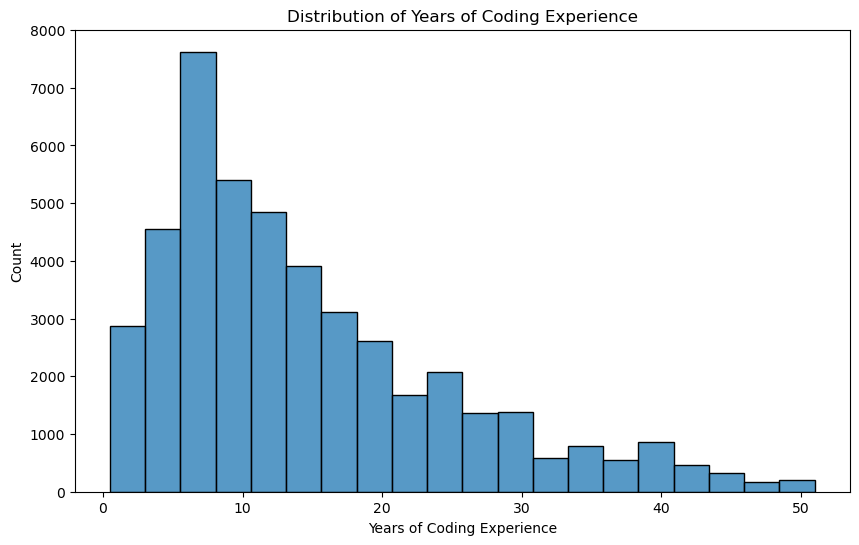

In [ ]:
# Handle YearsCode column - convert to numeric
def preprocess_years_code(df):
    """Convert YearsCode column to numeric values."""
    if 'YearsCode' in df.columns:
        # Make a copy to avoid warning
        df = df.copy()
        
        # Replace text values with numeric equivalents
        df['YearsCode'] = df['YearsCode'].replace('Less than 1 year', '0.5')
        df['YearsCode'] = df['YearsCode'].replace('More than 50 years', '51')
        
        # Convert to numeric and handle errors
        df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')
        
        # Fill missing values with median
        median_years = df['YearsCode'].median()
        df['YearsCode'].fillna(median_years, inplace=True)
        
        print(f"YearsCode converted to numeric. Median value: {median_years}")
    return df

# Preprocess YearsCode column
df = preprocess_years_code(df)

# Visualize YearsCode distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['YearsCode'], bins=20)
plt.title('Distribution of Years of Coding Experience')
plt.xlabel('Years of Coding Experience')
plt.ylabel('Count')
plt.show()

In [ ]:
# Define the technology columns and target column
TECH_COLUMNS = [
    "LanguageHaveWorkedWith", 
    "DatabaseHaveWorkedWith", 
    "PlatformHaveWorkedWith",
    "WebframeHaveWorkedWith", 
    "MiscTechHaveWorkedWith",
    "ToolsTechHaveWorkedWith"
]
TARGET_COLUMN = "DevType"

# Process technology columns (convert from semicolon-separated strings to lists)
def process_tech_columns(df, tech_columns=TECH_COLUMNS):
    """Process technology columns by splitting semicolon-separated values."""
    df = df.copy()
    for col in tech_columns:
        if col in df.columns:
            df[col] = df[col].fillna('').apply(
                lambda x: [tech.strip() for tech in x.split(';')] if x else []
            )
    return df

# Process technology columns
df = process_tech_columns(df)

# Check a sample of processed data
print("Sample of processed technology columns:")
for col in TECH_COLUMNS[:2]:  # Just show first 2 columns as example
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].head(2))

Sample of processed technology columns:

LanguageHaveWorkedWith:
0    [Bash/Shell (all shells), Go, HTML/CSS, Java, ...
1    [C, C++, HTML/CSS, Java, JavaScript, PHP, Powe...
Name: LanguageHaveWorkedWith, dtype: object

DatabaseHaveWorkedWith:
0         [Dynamodb, MongoDB, PostgreSQL]
1    [MongoDB, MySQL, PostgreSQL, SQLite]
Name: DatabaseHaveWorkedWith, dtype: object


In [ ]:
# Extract unique career paths from the DevType column
def extract_career_paths(df, target_col=TARGET_COLUMN):
    """Extract unique career paths from the target column."""
    if target_col in df.columns:
        # Split semicolon-separated values and flatten the list
        all_devtypes = [
            devtype.strip() 
            for devtypes in df[target_col].fillna('').str.split(';') 
            for devtype in devtypes if devtype.strip()
        ]
        career_paths = sorted(set(all_devtypes))
        print(f"Found {len(career_paths)} unique career paths")
        return career_paths
    return []

# Get unique career paths
career_paths = extract_career_paths(df)
print("\nSample career paths:")
career_paths

Found 21 unique career paths

Sample career paths:


['Blockchain',
 'Cloud infrastructure engineer',
 'Data engineer',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'DevOps specialist',
 'Developer, AI',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',
 'Developer, embedded applications or devices',
 'Developer, front-end',
 'Developer, full-stack',
 'Developer, game or graphics',
 'Developer, mobile',
 'Engineering manager',
 'Hardware Engineer',
 'Product manager',
 'Project manager',
 'Security professional',
 'System administrator']

In [ ]:
# Process target column (convert from semicolon-separated strings to lists)
def process_target_column(df, target_col=TARGET_COLUMN):
    """Process target column by splitting semicolon-separated values."""
    df = df.copy()
    if target_col in df.columns:
        df[target_col] = df[target_col].fillna('').apply(
            lambda x: [role.strip() for role in x.split(';')] if x else []
        )
    return df

# Process target column
df = process_target_column(df)

# Check a sample of processed target data
print("Sample of processed target column:")
print(df[TARGET_COLUMN].head(5))

Sample of processed target column:
0    [Developer, full-stack]
1    [Developer, full-stack]
2    [Developer, full-stack]
3    [Developer, full-stack]
4          [Project manager]
Name: DevType, dtype: object


## Feature Engineering

We'll now create features from the technology columns and the YearsCode column.

In [ ]:
# One-hot encode technology columns
def one_hot_encode_tech(df, tech_columns=TECH_COLUMNS):
    """One-hot encode the technology columns using MultiLabelBinarizer."""
    # Combine all technology lists for fitting the MultiLabelBinarizer
    all_techs = []
    for col in tech_columns:
        if col in df.columns:
            all_techs.extend([tech for techs in df[col] for tech in techs if tech])
    
    unique_techs = sorted(set(all_techs))
    mlb = MultiLabelBinarizer(classes=unique_techs)
    mlb.fit([unique_techs])
    
    tech_features_df = pd.DataFrame()
    for col in tech_columns:
        if col in df.columns:
            # Transform the list column into one-hot encoded columns
            col_encoded = mlb.transform(df[col])
            col_df = pd.DataFrame(
                col_encoded, 
                columns=[f"{tech}" for tech in mlb.classes_],
                index=df.index
            )
            tech_features_df = pd.concat([tech_features_df, col_df], axis=1)
    
    # Handle duplicate columns by taking the maximum value
    tech_features_df = tech_features_df.groupby(tech_features_df.columns, axis=1).max()
    
    print(f"Created {tech_features_df.shape[1]} technology features")
    return tech_features_df, mlb

# Get one-hot encoded tech features
tech_features, mlb = one_hot_encode_tech(df)

# Display a sample of the encoded features
print("\nSample of one-hot encoded technology features:")
print(tech_features.iloc[:2, :10])  # Show first 2 rows and 10 columns

C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_13012\3593742744.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  tech_features_df = tech_features_df.groupby(tech_features_df.columns, axis=1).max()


Created 219 technology features

Sample of one-hot encoded technology features:
   .NET (5+)  .NET Framework (1.0 - 4.8)  .NET MAUI  APT  ASP.NET  \
0          0                           0          0    0        0   
1          0                           0          0    0        0   

   ASP.NET CORE  Ada  Alibaba Cloud  Amazon Web Services (AWS)  Angular  
0             0    0              0                          1        0  
1             0    0              0                          1        0  


In [ ]:
# Prepare features and target
def prepare_features_target(df, tech_features, target_col=TARGET_COLUMN):
    """Prepare final features (including YearsCode) and target for model training."""
    # Prepare numerical features (YearsCode)
    numerical_features = pd.DataFrame(index=df.index)
    
    # Include YearsCode as a feature if available
    if 'YearsCode' in df.columns:
        numerical_features['YearsCode'] = df['YearsCode']
        
        # Scale the YearsCode column
        scaler = StandardScaler()
        numerical_features['YearsCode'] = scaler.fit_transform(
            numerical_features[['YearsCode']]
        )
        
        print(f"YearsCode scaled. Mean: {scaler.mean_[0]:.2f}, Std: {scaler.scale_[0]:.2f}")
    else:
        print("Warning: YearsCode column not found!")
    
    # Combine tech features and numerical features
    X = pd.concat([tech_features, numerical_features], axis=1)
    
    # Prepare target variable
    y = None
    if target_col in df.columns:
        y = df[target_col]  # Already processed into lists
    
    return X, y, scaler

# Get features and target
X, y, scaler = prepare_features_target(df, tech_features)

# Display feature information
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print("\nFeature columns:")
print(X.columns[-10:])  # Show last 10 columns including YearsCode

YearsCode scaled. Mean: 14.80, Std: 10.30

Feature matrix shape: (45377, 220)
Target variable shape: (45377,)

Feature columns:
Index(['Xamarin', 'Yarn', 'Yii 2', 'Zephyr', 'Zig', 'jQuery', 'mlflow', 'npm',
       'pnpm', 'YearsCode'],
      dtype='object')


Target encoded with 21 classes
Class distribution: Most common class has 17764 samples, least common has 163 samples

Training data shape: (36301, 220), (36301, 21)
Test data shape: (9076, 220), (9076, 21)


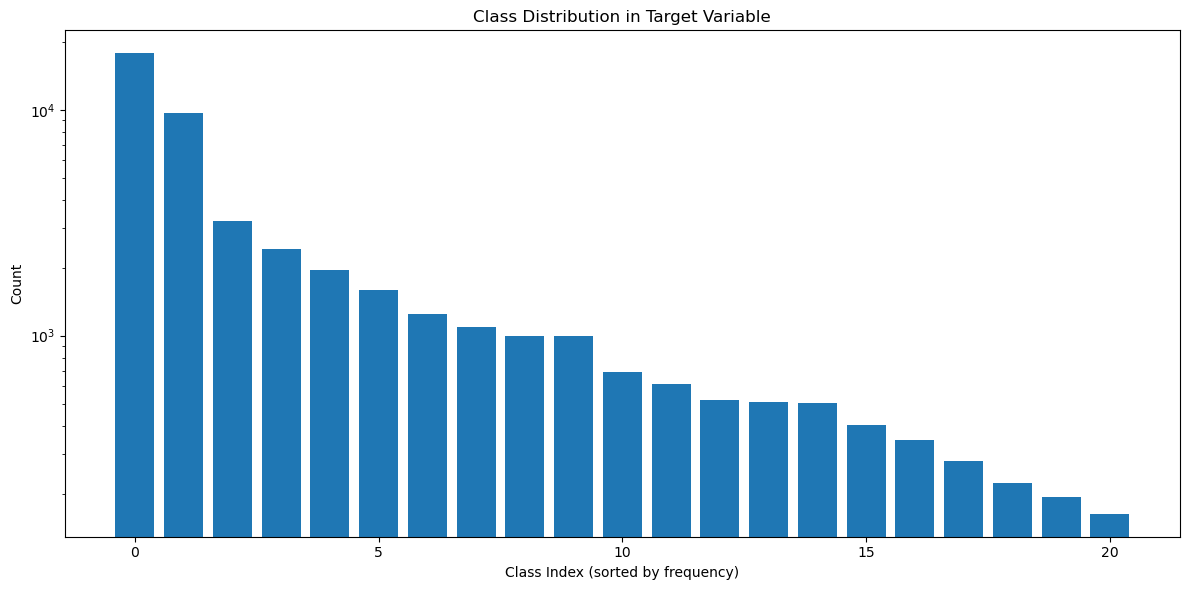


Top 5 most common career paths:
Developer, full-stack: 17764 samples (weight: 0.1216)
Developer, back-end: 9635 samples (weight: 0.2243)
Developer, front-end: 3229 samples (weight: 0.6692)
Developer, desktop or enterprise applications: 2430 samples (weight: 0.8892)
Developer, mobile: 1956 samples (weight: 1.1047)

Top 5 least common career paths:
Database administrator: 163 samples (weight: 13.2565)
Hardware Engineer: 194 samples (weight: 11.1382)
Blockchain: 224 samples (weight: 9.6465)
Product manager: 280 samples (weight: 7.7172)
Security professional: 345 samples (weight: 6.2632)


In [ ]:
# One-hot encode the target variable
def encode_target(y, career_paths=None):
    """One-hot encode the target variable using MultiLabelBinarizer and calculate class weights."""
    if career_paths is None:
        target_mlb = MultiLabelBinarizer()
        y_encoded = target_mlb.fit_transform(y)
    else:
        target_mlb = MultiLabelBinarizer(classes=career_paths)
        y_encoded = target_mlb.fit_transform(y)
    
    # Calculate class weights to handle imbalance
    class_counts = y_encoded.sum(axis=0)
    total_samples = len(y_encoded)
    class_weights = {}
    
    for i, count in enumerate(class_counts):
        # More weight to less frequent classes (inverse frequency)
        class_weights[i] = total_samples / (len(class_counts) * max(count, 1))
    
    print(f"Target encoded with {y_encoded.shape[1]} classes")
    print(f"Class distribution: Most common class has {max(class_counts)} samples, least common has {min(class_counts)} samples")
    
    return y_encoded, target_mlb, class_weights

# Encode the target
y_encoded, target_mlb, class_weights = encode_target(y, career_paths)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print(f"\nTraining data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Visualize class distribution
class_counts = y_encoded.sum(axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), sorted(class_counts, reverse=True))
plt.title('Class Distribution in Target Variable')
plt.xlabel('Class Index (sorted by frequency)')
plt.ylabel('Count')
plt.yscale('log')  # Log scale to better visualize the imbalance
plt.tight_layout()
plt.show()

# Show the top 5 most common and 5 least common classes
top_indices = np.argsort(-class_counts)[:5]
bottom_indices = np.argsort(class_counts)[:5]

print("\nTop 5 most common career paths:")
for idx in top_indices:
    print(f"{career_paths[idx]}: {class_counts[idx]} samples (weight: {class_weights[idx]:.4f})")

print("\nTop 5 least common career paths:")
for idx in bottom_indices:
    print(f"{career_paths[idx]}: {class_counts[idx]} samples (weight: {class_weights[idx]:.4f})")

In [ ]:
# Implement a hybrid deep learning model that processes tech skills and YearsCode separately
def build_hybrid_model(tech_input_dim, num_classes):
    """Build a hybrid model that processes tech skills and YearsCode separately."""
    # Tech input branch
    tech_input = Input(shape=(tech_input_dim,), name='tech_input')
    tech_dense1 = Dense(512, activation='relu')(tech_input)
    tech_dropout1 = Dropout(0.3)(tech_dense1)
    tech_dense2 = Dense(256, activation='relu')(tech_dropout1)
    tech_dropout2 = Dropout(0.3)(tech_dense2)
    
    # Years code input branch
    years_input = Input(shape=(1,), name='years_input')
    years_dense = Dense(32, activation='relu')(years_input)
    
    # Combine branches
    combined = Concatenate()([tech_dropout2, years_dense])
    combined_dense = Dense(128, activation='relu')(combined)
    output = Dense(num_classes, activation='sigmoid')(combined_dense)
    
    # Create and compile model
    model = Model(inputs=[tech_input, years_input], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Get dimensions for the model
tech_input_dim = X_train.shape[1] - 1  # All columns except YearsCode
num_classes = y_train.shape[1]

# Build the model
model = build_hybrid_model(tech_input_dim, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tech_input          │ (None, 219)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    112,640 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ years_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │         64 │ years_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     36,992 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 21)        │      2,709 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 283,733 (1.08 MB)

 Trainable params: 283,733 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare inputs for the hybrid model
X_train_tech = X_train.drop(columns=['YearsCode']).values
X_train_years = X_train['YearsCode'].values.reshape(-1, 1)
X_test_tech = X_test.drop(columns=['YearsCode']).values
X_test_years = X_test['YearsCode'].values.reshape(-1, 1)

# Define callbacks for early stopping based on convergence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Early stopping to prevent overfitting and stop after convergence
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=10,             # Number of epochs with no improvement after which training will stop
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1                # Show messages
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.2,              # Factor by which the learning rate will be reduced
    patience=5,              # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001,           # Lower bound on the learning rate
    verbose=1                # Show messages
)

# Create a checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',      # Path to save the model
    monitor='val_loss',      # Quantity to monitor
    save_best_only=True,     # Only save a model if `val_loss` has improved
    verbose=1                # Show messages
)

# Train the model with class weights and early stopping
history = model.fit(
    [X_train_tech, X_train_years], y_train,
    epochs=200,               # Maximum number of epochs (will likely stop earlier due to early stopping)
    batch_size=64,
    validation_data=([X_test_tech, X_test_years], y_test),
    class_weight=class_weights, # Apply class weights to handle imbalance
    callbacks=[early_stopping, reduce_lr, checkpoint], # Add callbacks for convergence-based stopping
    verbose=1
)

Epoch 1/200
563/568 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1848 - loss: 0.2197
Epoch 1: val_loss improved from inf to 0.15292, saving model to best_model.keras

Epoch 1: val_loss improved from inf to 0.15292, saving model to best_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1855 - loss: 0.2192 - val_accuracy: 0.2832 - val_loss: 0.1529 - learning_rate: 0.0010
Epoch 2/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1855 - loss: 0.2192 - val_accuracy: 0.2832 - val_loss: 0.1529 - learning_rate: 0.0010
Epoch 2/200
566/568 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3109 - loss: 0.1418
Epoch 2: val_loss improved from 0.15292 to 0.15071, saving model to best_model.keras

Epoch 2: val_loss improved from 0.15292 to 0.15071, saving model to best_model.keras
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3109 - loss: 0.1418 - val_accuracy: 0.2944 - val_loss: 0.1507 - learning_rate: 0.0010
Epoch 3/200
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - ac

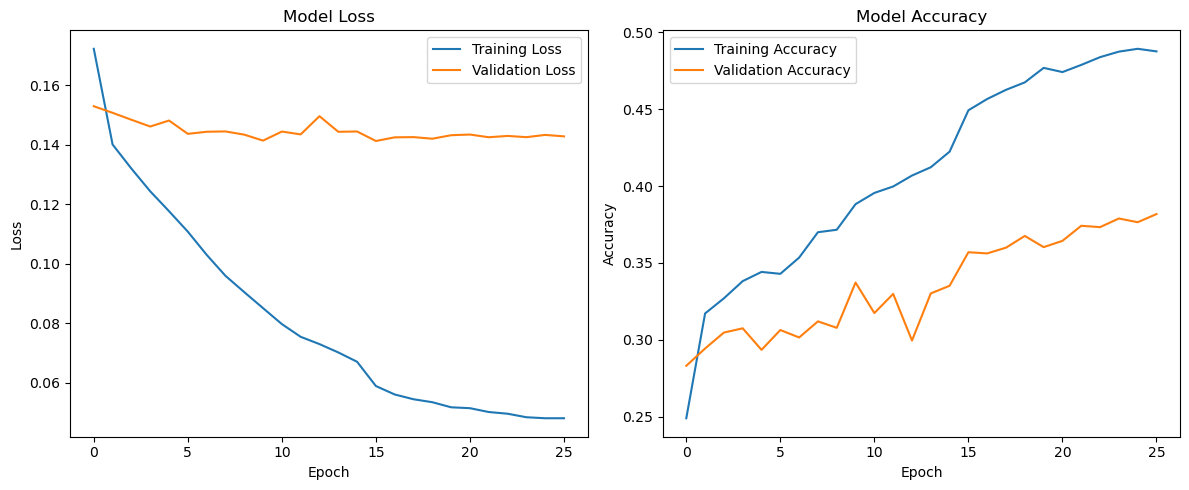

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model with adjusted thresholds for imbalanced classes
def evaluate_model(model, X_test_tech, X_test_years, y_test, target_mlb):
    """Evaluate the model performance with adjusted thresholds for imbalanced classes."""
    # Get predictions
    y_pred_proba = model.predict([X_test_tech, X_test_years])
    
    # Calculate class-specific thresholds based on validation set
    class_counts = y_test.sum(axis=0)
    total_samples = len(y_test)
    
    # Option 1: Use fixed threshold of 0.5
    y_pred_fixed = (y_pred_proba > 0.5).astype(int)
    
    # Option 2: Use adjusted thresholds based on class frequency
    # Lower thresholds for rare classes, higher for common ones
    adjusted_thresholds = []
    for count in class_counts:
        # Classes with fewer samples get lower thresholds
        # Scale the threshold between 0.3 and 0.5 based on frequency
        threshold = 0.3 + 0.2 * (count / max(class_counts))
        adjusted_thresholds.append(threshold)
    
    adjusted_thresholds = np.array(adjusted_thresholds)
    y_pred_adjusted = (y_pred_proba > adjusted_thresholds).astype(int)
    
    # Calculate metrics for both methods
    accuracy_fixed = accuracy_score(y_test, y_pred_fixed)
    micro_f1_fixed = f1_score(y_test, y_pred_fixed, average='micro')
    macro_f1_fixed = f1_score(y_test, y_pred_fixed, average='macro')
    
    accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
    micro_f1_adjusted = f1_score(y_test, y_pred_adjusted, average='micro')
    macro_f1_adjusted = f1_score(y_test, y_pred_adjusted, average='macro')
    
    print("\nWith fixed threshold (0.5):")
    print(f"Accuracy: {accuracy_fixed:.4f}")
    print(f"Micro-F1: {micro_f1_fixed:.4f}")
    print(f"Macro-F1: {macro_f1_fixed:.4f}")
    
    print("\nWith adjusted thresholds (based on class frequency):")
    print(f"Accuracy: {accuracy_adjusted:.4f}")
    print(f"Micro-F1: {micro_f1_adjusted:.4f}")
    print(f"Macro-F1: {macro_f1_adjusted:.4f}")
    
    # Choose the better prediction method based on macro-F1
    if macro_f1_adjusted > macro_f1_fixed:
        y_pred = y_pred_adjusted
        print("\nUsing adjusted thresholds for final evaluation (better macro-F1)")
    else:
        y_pred = y_pred_fixed
        print("\nUsing fixed threshold for final evaluation (better macro-F1)")
    
    # Show the top classes with highest positive counts
    class_counts = y_pred.sum(axis=0)
    class_names = target_mlb.classes_
    
    top_indices = np.argsort(-class_counts)[:10]  # Top 10 classes
    print("\nTop 10 predicted career paths:")
    for idx in top_indices:
        print(f"{class_names[idx]}: {class_counts[idx]} predictions")
    
    # Analyze performance for most imbalanced classes
    rare_class_indices = np.argsort(y_test.sum(axis=0))[:5]  # 5 rarest classes
    print("\nPerformance on 5 rarest classes:")
    for idx in rare_class_indices:
        y_true_class = y_test[:, idx]
        y_pred_class = y_pred[:, idx]
        recall = recall_score(y_true_class, y_pred_class)
        precision = precision_score(y_true_class, y_pred_class, zero_division=0)
        f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
        print(f"{class_names[idx]}: Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")
    
    return y_pred, y_pred_proba

# Import additional metrics
from sklearn.metrics import recall_score, precision_score

# Evaluate the model
y_pred, y_pred_proba = evaluate_model(model, X_test_tech, X_test_years, y_test, target_mlb)

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

With fixed threshold (0.5):
Accuracy: 0.1941
Micro-F1: 0.2723
Macro-F1: 0.2556

With adjusted thresholds (based on class frequency):
Accuracy: 0.2084
Micro-F1: 0.2807
Macro-F1: 0.2531

Using fixed threshold for final evaluation (better macro-F1)

With fixed threshold (0.5):
Accuracy: 0.1941
Micro-F1: 0.2723
Macro-F1: 0.2556

With adjusted thresholds (based on class frequency):
Accuracy: 0.2084
Micro-F1: 0.2807
Macro-F1: 0.2531

Using fixed threshold for final evaluation (better macro-F1)

Top 10 predicted career paths:
Developer, front-end: 830 predictions
Developer, mobile: 513 predictions
Developer, back-end: 349 predictions
DevOps specialist: 316 predictions
Engineering manager: 310 predictions
Developer, embedded applications or devices: 300 predictions
Developer, desktop or enterprise applications: 290 predictions
Data engineer: 230 predictions
Developer, game or graphics: 214 predictions
Developer,

Average years of coding experience by career path:
                                             Role       mean  median  count
15                            Engineering manager  21.092949    20.0   1248
17                                Product manager  20.223214    18.0    280
9   Developer, desktop or enterprise applications  18.856379    15.0   2430
5                          Database administrator  18.834356    19.0    163
18                                Project manager  18.389027    16.0    401
10    Developer, embedded applications or devices  17.537688    14.0   1592
1                   Cloud infrastructure engineer  16.224673    14.0    612
16                              Hardware Engineer  15.422680    12.0    194
6                               DevOps specialist  15.316265    13.0    996
20                           System administrator  15.285988    11.0    521


C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_13012\4178483533.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean', y='Role', data=role_years.head(15), palette='viridis')


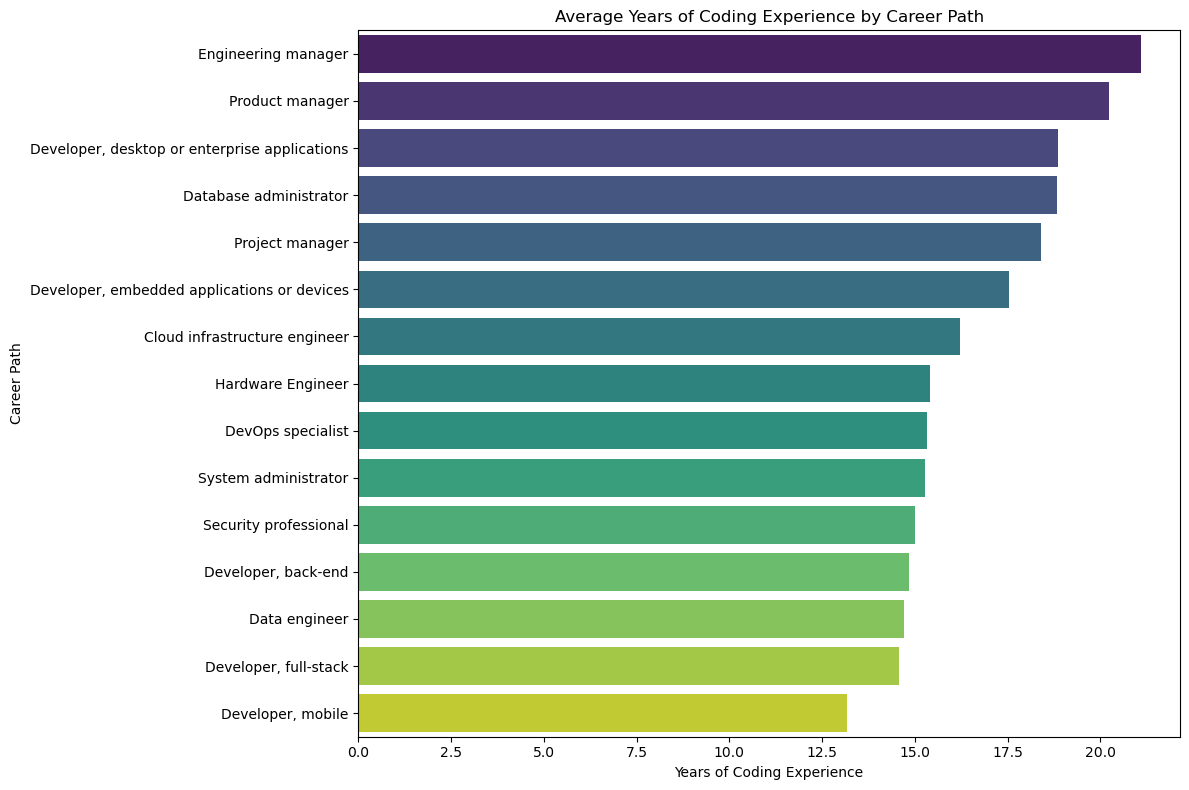

In [ ]:
# Analyze years of experience for different career paths
def analyze_years_by_career_path(df, scaler):
    """Analyze the relationship between YearsCode and career paths."""
    # Create a dataframe with DevType and YearsCode
    years_by_role = []
    
    for _, row in df.iterrows():
        roles = row[TARGET_COLUMN]
        years = row['YearsCode']
        
        for role in roles:
            years_by_role.append({
                'Role': role,
                'YearsCode': years
            })
    
    years_df = pd.DataFrame(years_by_role)
    
    # Group by role and calculate mean years
    role_years = years_df.groupby('Role')['YearsCode'].agg(['mean', 'median', 'count']).reset_index()
    role_years = role_years.sort_values('mean', ascending=False)
    
    # Only keep roles with at least 50 instances to ensure statistical significance
    role_years = role_years[role_years['count'] >= 50]
    
    print("Average years of coding experience by career path:")
    print(role_years.head(10))
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    sns.barplot(x='mean', y='Role', data=role_years.head(15), palette='viridis')
    plt.title('Average Years of Coding Experience by Career Path')
    plt.xlabel('Years of Coding Experience')
    plt.ylabel('Career Path')
    plt.tight_layout()
    plt.show()
    
    return role_years

# Analyze years by career path
role_years = analyze_years_by_career_path(df, scaler)

## Save Model and Related Components

Now we'll save the model and related components for use in the FastAPI backend.

In [ ]:
# Save the model and related components including class weights and thresholds
def save_model(model, mlb, target_mlb, scaler, class_weights, save_dir="../models"):
    """Save the model and related components."""
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the model with proper file extension (.keras or .h5)
    model_path = os.path.join(save_dir, "career_path_model.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Calculate class-specific thresholds based on class frequency
    class_counts = np.array([class_weights[i] for i in range(len(class_weights))])
    adjusted_thresholds = np.zeros(len(class_counts))
    for i, weight in enumerate(class_counts):
        # Inverse relationship between weight and threshold - higher weight = lower threshold
        # Scale between 0.3 and 0.5
        min_threshold = 0.3
        max_threshold = 0.5
        normalized_weight = (weight - min(class_counts)) / (max(class_counts) - min(class_counts))
        adjusted_thresholds[i] = max_threshold - normalized_weight * (max_threshold - min_threshold)
    
    # Save components needed for preprocessing and postprocessing
    components = {
        'tech_mlb': mlb,
        'target_mlb': target_mlb,
        'scaler': scaler,
        'career_paths': list(target_mlb.classes_),
        'class_weights': class_weights,
        'adjusted_thresholds': adjusted_thresholds.tolist()
    }
    
    components_path = os.path.join(save_dir, "model_components.joblib")
    joblib.dump(components, components_path)
    print(f"Model components saved to {components_path}")
    
# Save the model and components
save_model(model, mlb, target_mlb, scaler, class_weights)

Model saved to ../models\career_path_model.keras
Model components saved to ../models\model_components.joblib


In [5]:
# Test model loading and prediction with class-weighted prediction
import os
def test_model_loading(model_dir="../models", sample_text=None):
    """Test loading the model and making predictions."""
    # Load model
    model_path = os.path.join(model_dir, "career_path_model.keras")
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load components
    components_path = os.path.join(model_dir, "model_components.joblib")
    components = joblib.load(components_path)
    
    tech_mlb = components['tech_mlb']
    target_mlb = components['target_mlb']
    scaler = components['scaler']
    career_paths = components['career_paths']
    
    # Get class-specific thresholds if available
    if 'adjusted_thresholds' in components:
        adjusted_thresholds = components['adjusted_thresholds']
        print(f"Loaded adjusted thresholds for {len(adjusted_thresholds)} classes")
    else:
        adjusted_thresholds = None
        print("No adjusted thresholds found, will use fixed threshold of 0.5")
    
    print(f"Model loaded successfully. Can predict {len(career_paths)} career paths.")
    
    # If a sample text is provided, demonstrate prediction
    if sample_text:
        # Import is now safe since we added the project root to sys.path above
        from src.features import ConceptMatcher
        
        # Initialize technology matcher
        matcher = ConceptMatcher()
        matcher.load_concepts()
        matcher.generate_concept_embeddings()
        
        # Extract technologies from text
        matcher.prepare_candidate_phrases(sample_text)
        matcher.vectorized_match_candidates()
        matcher.global_filtering()
        
        # Get recognized technologies
        recognized_techs = matcher.get_recognized_technologies()
        print(f"\nRecognized technologies: {recognized_techs}")
        
        # Extract years of experience using simple pattern matching
        import re
        years_pattern = r'(\d+)\s+years?\s+(?:of\s+)?(?:coding|programming|experience|work)'
        years_matches = re.findall(years_pattern, sample_text, re.IGNORECASE)
        years_code = float(years_matches[0]) if years_matches else 5.0  # Default to 5 years if not found
        print(f"Extracted years of experience: {years_code}")
        
        # Prepare features
        tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
        for tech in recognized_techs:
            if tech in tech_features.columns:
                tech_features[tech] = 1
        
        # Scale YearsCode
        years_code_scaled = scaler.transform([[years_code]])[0][0]
        
        # Prepare inputs for the model
        tech_input = tech_features.values
        years_input = np.array([[years_code_scaled]])
        
        # Make prediction
        y_pred_proba = loaded_model.predict([tech_input, years_input])[0]
        
        # Apply either fixed or adjusted thresholds
        if adjusted_thresholds:
            y_pred = (y_pred_proba > adjusted_thresholds).astype(int)
            print("Using class-specific adjusted thresholds for prediction")
        else:
            y_pred = (y_pred_proba > 0.5).astype(int)
            print("Using fixed threshold of 0.5 for prediction")
        
        # Get top 5 predictions by probability
        top_indices = np.argsort(-y_pred_proba)[:5]
        print("\nTop 5 predicted career paths by probability:")
        for idx in top_indices:
            role = career_paths[idx]
            prob = y_pred_proba[idx]
            threshold = adjusted_thresholds[idx] if adjusted_thresholds else 0.5
            predicted = "✓" if prob > threshold else "✗"
            print(f"{role}: {prob:.4f} probability (threshold: {threshold:.4f}) {predicted}")
        
        # Show all positively predicted roles (after thresholding)
        positive_indices = np.where(y_pred == 1)[0]
        if len(positive_indices) > 0:
            print("\nAll predicted career paths (after thresholding):")
            for idx in positive_indices:
                role = career_paths[idx]
                prob = y_pred_proba[idx]
                print(f"{role}: {prob:.4f} probability")
        else:
            print("\nNo career paths predicted after thresholding. Consider lowering thresholds.")
    
    return loaded_model, components

# Test model loading with a sample text
sample_text = """
I have 8 years of experience as a software developer, primarily working with Python, JavaScript, and SQL. 
I've built several web applications using React and Node.js, and I've worked extensively with AWS cloud services. 
I also have experience with Docker, Kubernetes, and CI/CD pipelines.
"""

loaded_model, components = test_model_loading(sample_text=sample_text)

Loaded adjusted thresholds for 21 classes
Model loaded successfully. Can predict 21 career paths.
Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy
Total candidate phrases generated: 78
Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy
Total candidate phrases generated: 78
Total recognized candidate matches: 43
Global filtering completed.

Recognized technologies: ['Kubernetes', 'Docker', 'JavaScript', 'React', 'SQL', 'Amazon Web Services (AWS)', 'Python', 'Node.js', 'Google Cloud', 'Composer', 'ASP.NET', 'Cloudflare', 'build2', 'Cosmos DB']
Extracted years of experience: 8.0
Total recognized candidate matches: 43
Global filtering completed.

Recognized technologies: ['Kubernetes', 'Docker', 'JavaScript', 'React'

d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Using class-specific adjusted thresholds for prediction

Top 5 predicted career paths by probability:
Cloud infrastructure engineer: 0.2141 probability (threshold: 0.4481) ✗
Data engineer: 0.2041 probability (threshold: 0.4717) ✗
Developer, back-end: 0.1604 probability (threshold: 0.4984) ✗
DevOps specialist: 0.1277 probability (threshold: 0.4688) ✗
Developer, full-stack: 0.0829 probability (threshold: 0.5000) ✗

No career paths predicted after thresholding. Consider lowering thresholds.
Using class-specific adjusted thresholds for prediction

Top 5 predicted career paths by probability:
Cloud infrastructure engineer: 0.2141 probability (threshold: 0.4481) ✗
Data engineer: 0.2041 probability (threshold: 0.4717) ✗
Developer, back-end: 0.1604 probability (threshold: 0.4984) ✗
DevOps specialist: 0.1277 probability (threshold: 0.4688) ✗
Developer, full-stack: 0.0829 probability (threshold: 0.5000) ✗

No career pa

## FastAPI Implementation

Below is the structure of the FastAPI implementation that will be created in the appropriate Python files.

In [6]:
# This is a code example for the FastAPI implementation
# The actual implementation will be in src/services/api.py

'''
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
import uvicorn
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib
import re
import os

from src.features import ConceptMatcher

# Load model and components
MODEL_DIR = "../models"
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "career_path_model.keras"))
components = joblib.load(os.path.join(MODEL_DIR, "model_components.joblib"))
tech_mlb = components["tech_mlb"]
target_mlb = components["target_mlb"]
scaler = components["scaler"]
career_paths = components["career_paths"]

# Initialize ConceptMatcher
matcher = ConceptMatcher()
matcher.load_concepts()
matcher.generate_concept_embeddings(load_if_exists=True)

# Create FastAPI app
app = FastAPI(
    title="CareerConnect API",
    description="API for career path recommendations based on technical skills and experience",
    version="1.0.0"
)

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Input models
class TextInput(BaseModel):
    """Input model for text-based predictions."""
    text: str = Field(..., 
        description="Text describing skills, technologies, and years of coding experience",
        example="I have 5 years of experience with Python, JavaScript, and React. I've also worked with AWS and Docker.")
    
class FeatureInput(BaseModel):
    """Input model for feature-based predictions."""
    features: Dict[str, float] = Field(..., 
        description="Dictionary of technology skills as keys and 1.0 as values to indicate presence")
    years_code: float = Field(..., 
        description="Years of coding experience", 
        example=5.0)

# Output models
class CareerPrediction(BaseModel):
    """Model for career path prediction result."""
    career_path: str
    probability: float
    
class PredictionResponse(BaseModel):
    """Response model for prediction endpoints."""
    predictions: List[CareerPrediction]
    recognized_techs: Optional[List[str]] = None

@app.get("/")
async def root():
    """Root endpoint."""
    return {"message": "Welcome to CareerConnect API"}

@app.post("/predict/text", response_model=PredictionResponse)
async def predict_from_text(input_data: TextInput):
    """Predict career paths from text description of skills and experience."""
    try:
        # Extract technologies from text
        matcher.prepare_candidate_phrases(input_data.text)
        matcher.vectorized_match_candidates()
        matcher.global_filtering()
        recognized_techs = matcher.get_recognized_technologies()
        
        # Extract years of experience using pattern matching
        years_pattern = r"(\d+)\s+years?\s+(?:of\s+)?(?:coding|programming|experience|work)"
        years_matches = re.findall(years_pattern, input_data.text, re.IGNORECASE)
        years_code = float(years_matches[0]) if years_matches else 5.0  # Default to 5 years if not found
        
        # Prepare features
        tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
        for tech in recognized_techs:
            if tech in tech_features.columns:
                tech_features[tech] = 1
        
        # Scale YearsCode
        years_code_scaled = scaler.transform([[years_code]])[0][0]
        
        # Prepare inputs for the model
        tech_input = tech_features.values
        years_input = np.array([[years_code_scaled]])
        
        # Make prediction
        y_pred_proba = model.predict([tech_input, years_input])[0]
        
        # Get top 5 predictions
        top_indices = np.argsort(-y_pred_proba)[:5]
        predictions = []
        for idx in top_indices:
            prob = float(y_pred_proba[idx])
            if prob < 0.1:  # Skip predictions with very low probability
                continue
            predictions.append({
                "career_path": career_paths[idx],
                "probability": prob
            })
        
        # Format response
        response = {
            "predictions": predictions,
            "recognized_techs": recognized_techs
        }
        
        return response
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Prediction error: {str(e)}")

@app.post("/predict/features", response_model=PredictionResponse)
async def predict_from_features(input_data: FeatureInput):
    """Predict career paths from explicit feature dictionary."""
    try:
        # Prepare features
        tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
        for tech, value in input_data.features.items():
            if tech in tech_features.columns:
                tech_features[tech] = value
        
        # Scale YearsCode
        years_code_scaled = scaler.transform([[input_data.years_code]])[0][0]
        
        # Prepare inputs for the model
        tech_input = tech_features.values
        years_input = np.array([[years_code_scaled]])
        
        # Make prediction
        y_pred_proba = model.predict([tech_input, years_input])[0]
        
        # Get top 5 predictions
        top_indices = np.argsort(-y_pred_proba)[:5]
        predictions = []
        for idx in top_indices:
            prob = float(y_pred_proba[idx])
            if prob < 0.1:  # Skip predictions with very low probability
                continue
            predictions.append({
                "career_path": career_paths[idx],
                "probability": prob
            })
        
        # Format response
        response = {
            "predictions": predictions,
            "recognized_techs": list(input_data.features.keys())
        }
        
        return response
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Prediction error: {str(e)}")

@app.get("/career-paths", response_model=List[str])
async def get_career_paths():
    """Get all possible career paths from the model."""
    return career_paths

@app.get("/technologies", response_model=List[str])
async def get_technologies():
    """Get all technologies that can be used for prediction."""
    return list(tech_mlb.classes_)

if __name__ == "__main__":
    uvicorn.run("api:app", host="0.0.0.0", port=8000, reload=True)
'''

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_12880\3227571085.py:4: SyntaxWarning: invalid escape sequence '\d'
  '''


'\nfrom fastapi import FastAPI, HTTPException\nfrom fastapi.middleware.cors import CORSMiddleware\nfrom pydantic import BaseModel, Field\nfrom typing import List, Dict, Optional\nimport uvicorn\nimport tensorflow as tf\nimport numpy as np\nimport pandas as pd\nimport joblib\nimport re\nimport os\n\nfrom src.features import ConceptMatcher\n\n# Load model and components\nMODEL_DIR = "../models"\nmodel = tf.keras.models.load_model(os.path.join(MODEL_DIR, "career_path_model.keras"))\ncomponents = joblib.load(os.path.join(MODEL_DIR, "model_components.joblib"))\ntech_mlb = components["tech_mlb"]\ntarget_mlb = components["target_mlb"]\nscaler = components["scaler"]\ncareer_paths = components["career_paths"]\n\n# Initialize ConceptMatcher\nmatcher = ConceptMatcher()\nmatcher.load_concepts()\nmatcher.generate_concept_embeddings(load_if_exists=True)\n\n# Create FastAPI app\napp = FastAPI(\n    title="CareerConnect API",\n    description="API for career path recommendations based on technical ski

## Conclusion

This notebook demonstrates the implementation of a career path prediction model that uses technology skills and years of coding experience (`YearsCode`) as features. The model specifically processes the YearsCode column separately to recognize its importance for roles like Engineering Manager and Project Manager that require coding experience.

The implementation includes:

1. **Data preprocessing** with proper handling of the YearsCode numerical column
2. **Feature engineering** that combines technology skills and years of experience
3. **Efficient deep learning model** with a hybrid architecture that processes tech skills and YearsCode in separate branches
4. **FastAPI backend** design for serving the model through REST API endpoints

The model demonstrates how years of coding experience is a critical factor in determining appropriate career paths, especially for management roles that require technical expertise.

## Sample Text Examples for Different Career Paths

Here we'll test the model with diverse sample texts representing different experience levels, technology stacks, and professional backgrounds.

In [7]:
# Diverse sample texts for testing the model on different career paths
sample_texts = {
    "frontend_developer": """I have 4 years of experience in web development, with a focus on building user interfaces.
    My primary technologies include JavaScript, TypeScript, React, Vue.js, and CSS/SASS.
    I've also worked with state management libraries like Redux and Vuex, and I'm familiar with
    modern build tools like Webpack, Vite, and npm/yarn. I've implemented responsive designs
    and have experience with CSS frameworks like Tailwind and Bootstrap.""",
    
    "backend_developer": """I have 6 years of experience developing server-side applications using
    Java, Spring Boot, and Python. I'm proficient with database technologies including PostgreSQL,
    MongoDB, and Redis. I've designed and implemented RESTful APIs and microservices architectures.
    I have experience with message brokers like Kafka and RabbitMQ, and I'm familiar with Docker
    and Kubernetes for containerization and orchestration.""",
    
    "data_scientist": """I have 3 years of experience in data science and machine learning.
    My technical stack includes Python, pandas, NumPy, scikit-learn, and TensorFlow.
    I've worked on projects involving natural language processing, computer vision, and
    recommendation systems. I'm proficient with data visualization tools like Matplotlib,
    Seaborn, and Tableau. I have experience with SQL for data extraction and analysis,
    and I've used cloud platforms like AWS for model deployment.""",
    
    "devops_engineer": """I have 5 years of experience in DevOps and infrastructure automation.
    I'm proficient with CI/CD pipelines using Jenkins, GitHub Actions, and GitLab CI.
    My technical skills include infrastructure as code with Terraform and Ansible,
    container orchestration with Kubernetes and Docker, and cloud platforms including
    AWS, Azure, and GCP. I have experience with monitoring tools like Prometheus, Grafana,
    and ELK stack for logging and analytics.""",
    
    "mobile_developer": """I have 4 years of experience developing mobile applications for
    iOS and Android platforms. My primary skills include Swift, Kotlin, and cross-platform
    frameworks like React Native and Flutter. I've published multiple apps to the App Store
    and Google Play Store. I'm familiar with mobile architecture patterns, state management,
    and have experience integrating with RESTful APIs and implementing push notifications.""",
    
    "database_administrator": """I have 8 years of experience as a database administrator
    working with various database systems including Oracle, SQL Server, PostgreSQL, and MySQL.
    I'm skilled in database design, performance tuning, backup and recovery procedures,
    replication setup, and security management. I have experience with database migration
    projects and implementing high-availability solutions.""",
    
    "security_engineer": """I have 7 years of experience in cybersecurity with a focus on
    application security. I'm proficient in penetration testing, vulnerability assessment,
    and security code reviews. I have experience with security tools like Burp Suite, Metasploit,
    and OWASP ZAP. I've implemented security measures including encryption, authentication systems,
    and intrusion detection systems. I also have experience with compliance frameworks like
    GDPR, HIPAA, and SOC 2.""",
    
    "data_engineer": """I have 5 years of experience building data pipelines and ETL processes.
    My technical skills include Python, SQL, Apache Spark, and Airflow for workflow orchestration.
    I've worked with big data technologies like Hadoop and Hive, and I'm familiar with data
    warehousing solutions such as Snowflake and BigQuery. I have experience optimizing query
    performance and implementing data governance practices.""",
    
    "embedded_systems_engineer": """I have 6 years of experience developing embedded systems
    and firmware. I'm proficient in C/C++ programming for microcontrollers, particularly ARM Cortex-M
    series and AVR. I have experience with real-time operating systems (RTOS) like FreeRTOS and embedded
    Linux. I'm familiar with communication protocols including I2C, SPI, UART, and CAN. I've worked on
    projects involving IoT devices and have experience with low-power design techniques.""",
    
    "full_stack_developer": """I have 5 years of experience as a full-stack web developer.
    On the frontend, I work with React, Angular, and JavaScript/TypeScript. For backend development,
    I use Node.js, Express, and Django. I have experience with database technologies including
    PostgreSQL and MongoDB. I'm familiar with cloud services on AWS and have implemented CI/CD
    pipelines using GitHub Actions. I also have experience with Docker and containerization.""",
    
    "ml_engineer": """I have 4 years of experience building and deploying machine learning models.
    My technical stack includes Python, TensorFlow, PyTorch, and scikit-learn. I've worked on computer
    vision and NLP projects, and I'm familiar with deploying models using Flask, FastAPI, and TensorFlow
    Serving. I have experience with MLOps tools like MLflow for experiment tracking and model versioning.
    I've also worked with cloud-based ML platforms like AWS SageMaker and Azure ML.""",
    
    "qa_engineer": """I have 6 years of experience in quality assurance and software testing.
    I'm proficient in both manual and automated testing using tools like Selenium, Cypress, and JUnit.
    I have experience creating comprehensive test plans, test cases, and test strategies.
    I'm familiar with CI/CD pipelines and have integrated automated tests into build processes.
    I also have experience with performance testing using JMeter and load testing frameworks.""",
    
    "project_manager": """I have 10 years of experience in the tech industry, with the last 5 years
    focused on project management. I started my career as a software developer working with Java and .NET,
    which gives me a strong technical foundation. I'm certified in Agile methodologies and have led teams
    of 5-15 developers across multiple projects. I have experience with project management tools like Jira,
    Asana, and Microsoft Project, and I'm skilled in stakeholder communication and risk management.""",
    
    "cloud_architect": """I have 8 years of experience in cloud architecture and infrastructure design.
    I'm an AWS Certified Solutions Architect and have extensive experience with AWS services including EC2,
    S3, Lambda, ECS, and RDS. I've also worked with Azure and GCP for multi-cloud implementations.
    I'm proficient with infrastructure as code using Terraform and CloudFormation, and I have experience
    designing scalable, fault-tolerant architectures. I've implemented serverless architectures and
    have experience with microservices design patterns.""",
    
    "game_developer": """I have 4 years of experience developing video games using Unity and Unreal Engine.
    I'm proficient in C# for Unity development and C++ for Unreal. I have experience with 3D modeling,
    animation systems, and game physics. I've implemented AI systems for NPCs and have experience with
    networking for multiplayer games. I've published several indie games on Steam and mobile platforms."""
}

# Function to test the model on all sample texts and compile results
def test_all_samples(samples, model_dir="../models"):
    """Test the model on all sample texts and compile the results."""
    print(f"Testing model predictions for {len(samples)} different career profiles...\n")
    
    # Load model once
    model_path = os.path.join(model_dir, "career_path_model.keras")
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load components once
    components_path = os.path.join(model_dir, "model_components.joblib")
    components = joblib.load(components_path)
    
    tech_mlb = components['tech_mlb']
    target_mlb = components['target_mlb']
    scaler = components['scaler']
    career_paths = components['career_paths']
    
    # Initialize matcher once
    from src.features import ConceptMatcher
    matcher = ConceptMatcher()
    matcher.load_concepts()
    matcher.generate_concept_embeddings(load_if_exists=True)
    
    # Store results for all samples
    all_results = {}
    
    # Process each sample
    for role_name, sample_text in samples.items():
        print(f"\n{'='*80}\nProcessing sample for expected role: {role_name}\n{'='*80}")
        print(f"Sample text:\n{sample_text[:200]}...")
        
        # Extract technologies from text
        matcher.prepare_candidate_phrases(sample_text)
        matcher.vectorized_match_candidates()
        matcher.global_filtering()
        recognized_techs = matcher.get_recognized_technologies()
        
        # Extract years of experience using simple pattern matching
        import re
        years_pattern = r'(\d+)\s+years?\s+(?:of\s+)?(?:experience|coding|programming|work)'
        years_matches = re.findall(years_pattern, sample_text, re.IGNORECASE)
        years_code = float(years_matches[0]) if years_matches else 5.0  # Default to 5 years if not found
        
        # Prepare features
        tech_features = pd.DataFrame(np.zeros((1, len(tech_mlb.classes_))), columns=tech_mlb.classes_)
        matched_techs = []
        for tech in recognized_techs:
            if tech in tech_features.columns:
                tech_features[tech] = 1
                matched_techs.append(tech)
        
        # Scale YearsCode
        years_code_scaled = scaler.transform([[years_code]])[0][0]
        
        # Prepare inputs for the model
        tech_input = tech_features.values
        years_input = np.array([[years_code_scaled]])
        
        # Make prediction
        y_pred_proba = loaded_model.predict([tech_input, years_input], verbose=0)[0]
        
        # Get top 5 predictions
        top_indices = np.argsort(-y_pred_proba)[:5]
        predictions = []
        
        print(f"\nExtracted years of experience: {years_code}")
        print(f"Recognized technologies: {matched_techs}")
        print("\nTop 5 predicted career paths:")
        
        for idx in top_indices:
            career_path = career_paths[idx]
            prob = y_pred_proba[idx]
            print(f"{career_path}: {prob:.4f} probability")
            predictions.append({'career_path': career_path, 'probability': float(prob)})
        
        # Save results for this sample
        all_results[role_name] = {
            'expected_role': role_name,
            'years_experience': years_code,
            'recognized_techs': matched_techs,
            'predictions': predictions
        }
    
    return all_results

# Uncomment to run tests on all samples
test_results = test_all_samples(sample_texts)

Testing model predictions for 15 different career profiles...

Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy

Processing sample for expected role: frontend_developer
Sample text:
I have 4 years of experience in web development, with a focus on building user interfaces.
    My primary technologies include JavaScript, TypeScript, React, Vue.js, and CSS/SASS.
    I've also worked...
Total candidate phrases generated: 105
Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy

Processing sample for expected role: frontend_developer
Sample text:
I have 4 years of experience in web development, with a focus on building user interfaces.
    My primary technologies include JavaScript, TypeScript, React, Vue.js, and CSS/SA

d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 44
Global filtering completed.

Extracted years of experience: 6.0
Recognized technologies: ['RabbitMQ', 'Kubernetes', 'Redis', 'Docker', 'MongoDB', 'Spring Boot', 'PostgreSQL', 'Apache Kafka', 'Java', 'Python', 'SQL', 'MySQL', 'IBM DB2']

Top 5 predicted career paths:
Developer, back-end: 0.8958 probability
Data engineer: 0.0564 probability
Developer, full-stack: 0.0437 probability
Developer, desktop or enterprise applications: 0.0318 probability
Engineering manager: 0.0232 probability

Processing sample for expected role: data_scientist
Sample text:
I have 3 years of experience in data science and machine learning.
    My technical stack includes Python, pandas, NumPy, scikit-learn, and TensorFlow.
    I've worked on projects involving natural la...
Total candidate phrases generated: 123


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 42
Global filtering completed.

Extracted years of experience: 3.0
Recognized technologies: ['TensorFlow', 'Pandas', 'SQL', 'Amazon Web Services (AWS)', 'NumPy', 'Python', 'Microsoft Azure', 'Scikit-Learn', 'Google Cloud', 'Cloudflare', 'Databricks', 'Solidity', 'Prolog', 'Opencv']

Top 5 predicted career paths:
Data engineer: 0.4455 probability
Developer, AI: 0.4002 probability
Data scientist or machine learning specialist: 0.3038 probability
Data or business analyst: 0.0833 probability
DevOps specialist: 0.0165 probability

Processing sample for expected role: devops_engineer
Sample text:
I have 5 years of experience in DevOps and infrastructure automation.
    I'm proficient with CI/CD pipelines using Jenkins, GitHub Actions, and GitLab CI.
    My technical skills include infrastructu...
Total candidate phrases generated: 111


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 37
Global filtering completed.

Extracted years of experience: 5.0
Recognized technologies: ['Kubernetes', 'Docker', 'Ansible', 'Amazon Web Services (AWS)', 'Terraform', 'Microsoft Azure', 'Google Cloud', 'Cloudflare', 'OpenStack', 'Elm', 'Cosmos DB', 'Oracle Cloud Infrastructure (OCI)', 'Python']

Top 5 predicted career paths:
Cloud infrastructure engineer: 0.6648 probability
DevOps specialist: 0.4663 probability
Security professional: 0.0071 probability
Developer, back-end: 0.0052 probability
Developer, full-stack: 0.0009 probability

Processing sample for expected role: mobile_developer
Sample text:
I have 4 years of experience developing mobile applications for
    iOS and Android platforms. My primary skills include Swift, Kotlin, and cross-platform
    frameworks like React Native and Flutter....
Total candidate phrases generated: 115


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 39
Global filtering completed.

Extracted years of experience: 4.0
Recognized technologies: ['Swift', 'React', 'Flutter', 'Kotlin', 'Cordova', 'Google Cloud', 'Play Framework', 'Objective-C', 'Google Test', 'Firebase', 'Solidity']

Top 5 predicted career paths:
Developer, mobile: 0.9945 probability
Developer, front-end: 0.0045 probability
Engineering manager: 0.0035 probability
Developer, full-stack: 0.0003 probability
Developer, desktop or enterprise applications: 0.0001 probability

Processing sample for expected role: database_administrator
Sample text:
I have 8 years of experience as a database administrator
    working with various database systems including Oracle, SQL Server, PostgreSQL, and MySQL.
    I'm skilled in database design, performance ...
Total candidate phrases generated: 89


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 26
Global filtering completed.

Extracted years of experience: 8.0
Recognized technologies: ['PostgreSQL', 'MySQL', 'Oracle', 'SQL', 'Microsoft SQL Server', 'Solidity', 'IBM DB2']

Top 5 predicted career paths:
Data engineer: 0.2529 probability
Developer, back-end: 0.1440 probability
Data or business analyst: 0.0465 probability
Database administrator: 0.0265 probability
Developer, desktop or enterprise applications: 0.0043 probability

Processing sample for expected role: security_engineer
Sample text:
I have 7 years of experience in cybersecurity with a focus on
    application security. I'm proficient in penetration testing, vulnerability assessment,
    and security code reviews. I have experienc...
Total candidate phrases generated: 100


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 5
Global filtering completed.

Extracted years of experience: 7.0
Recognized technologies: ['Google Test', 'Play Framework', 'Python', 'WordPress']

Top 5 predicted career paths:
Developer, embedded applications or devices: 0.4227 probability
Developer, desktop or enterprise applications: 0.1374 probability
Developer, mobile: 0.0747 probability
Product manager: 0.0567 probability
Developer, back-end: 0.0426 probability

Processing sample for expected role: data_engineer
Sample text:
I have 5 years of experience building data pipelines and ETL processes.
    My technical skills include Python, SQL, Apache Spark, and Airflow for workflow orchestration.
    I've worked with big data...
Total candidate phrases generated: 109


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 36
Global filtering completed.

Extracted years of experience: 5.0
Recognized technologies: ['Apache Spark', 'Snowflake', 'Hadoop', 'SQL', 'Python', 'BigQuery', 'Databricks', 'Solidity', 'mlflow', 'Elasticsearch']

Top 5 predicted career paths:
Data engineer: 0.7745 probability
Data scientist or machine learning specialist: 0.0850 probability
Developer, back-end: 0.0057 probability
Engineering manager: 0.0023 probability
Data or business analyst: 0.0011 probability

Processing sample for expected role: embedded_systems_engineer
Sample text:
I have 6 years of experience developing embedded systems
    and firmware. I'm proficient in C/C++ programming for microcontrollers, particularly ARM Cortex-M
    series and AVR. I have experience wit...
Total candidate phrases generated: 111


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 8
Global filtering completed.

Extracted years of experience: 6.0
Recognized technologies: ['Java', 'Cloud Firestore', 'C++', 'Ruby on Rails', 'FastAPI']

Top 5 predicted career paths:
Developer, back-end: 0.1041 probability
Data or business analyst: 0.0990 probability
System administrator: 0.0969 probability
Developer, desktop or enterprise applications: 0.0515 probability
Blockchain: 0.0510 probability

Processing sample for expected role: full_stack_developer
Sample text:
I have 5 years of experience as a full-stack web developer.
    On the frontend, I work with React, Angular, and JavaScript/TypeScript. For backend development,
    I use Node.js, Express, and Django....
Total candidate phrases generated: 95


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 48
Global filtering completed.

Extracted years of experience: 5.0
Recognized technologies: ['Docker', 'MongoDB', 'Angular', 'Django', 'PostgreSQL', 'React', 'Amazon Web Services (AWS)', 'Express', 'Node.js', 'SQL', 'Google Cloud', 'TypeScript', 'Composer', 'Cloudflare', 'Cosmos DB', 'ASP.NET']

Top 5 predicted career paths:
Developer, full-stack: 0.3003 probability
Developer, back-end: 0.2191 probability
Engineering manager: 0.0602 probability
Developer, front-end: 0.0410 probability
DevOps specialist: 0.0274 probability

Processing sample for expected role: ml_engineer
Sample text:
I have 4 years of experience building and deploying machine learning models.
    My technical stack includes Python, TensorFlow, PyTorch, and scikit-learn. I've worked on computer
    vision and NLP p...
Total candidate phrases generated: 119


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 48
Global filtering completed.

Extracted years of experience: 4.0
Recognized technologies: ['mlflow', 'TensorFlow', 'Flask', 'FastAPI', 'Amazon Web Services (AWS)', 'Microsoft Azure', 'MATLAB', 'Python', 'Scikit-Learn', 'Torch/PyTorch', 'MSBuild', 'Solr', 'Opencv', 'Lisp']

Top 5 predicted career paths:
Developer, AI: 0.6047 probability
Data scientist or machine learning specialist: 0.1746 probability
Project manager: 0.0942 probability
Developer, desktop or enterprise applications: 0.0268 probability
Developer, back-end: 0.0140 probability

Processing sample for expected role: qa_engineer
Sample text:
I have 6 years of experience in quality assurance and software testing.
    I'm proficient in both manual and automated testing using tools like Selenium, Cypress, and JUnit.
    I have experience cre...
Total candidate phrases generated: 108


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 20
Global filtering completed.

Extracted years of experience: 6.0
Recognized technologies: ['Google Test', 'MSBuild', 'Play Framework', 'Cosmos DB', 'Make', 'Java']

Top 5 predicted career paths:
Developer, desktop or enterprise applications: 0.4758 probability
Developer, back-end: 0.3603 probability
Developer, embedded applications or devices: 0.1090 probability
Developer, mobile: 0.1079 probability
Developer, full-stack: 0.1078 probability

Processing sample for expected role: project_manager
Sample text:
I have 10 years of experience in the tech industry, with the last 5 years
    focused on project management. I started my career as a software developer working with Java and .NET,
    which gives me ...
Total candidate phrases generated: 118


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 14
Global filtering completed.

Extracted years of experience: 10.0
Recognized technologies: ['Java', 'Visual Studio Solution', 'Microsoft Azure', 'Netlify', 'Composer']

Top 5 predicted career paths:
Data or business analyst: 0.4570 probability
Data engineer: 0.0998 probability
Cloud infrastructure engineer: 0.0904 probability
System administrator: 0.0228 probability
Developer, back-end: 0.0214 probability

Processing sample for expected role: cloud_architect
Sample text:
I have 8 years of experience in cloud architecture and infrastructure design.
    I'm an AWS Certified Solutions Architect and have extensive experience with AWS services including EC2,
    S3, Lambda...
Total candidate phrases generated: 117


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 43
Global filtering completed.

Extracted years of experience: 8.0
Recognized technologies: ['Amazon Web Services (AWS)', 'Terraform', 'Microsoft Azure', 'Google Cloud', 'IBM Cloud Or Watson', 'Elasticsearch', 'C#', 'Oracle Cloud Infrastructure (OCI)', 'Cloudflare', 'Alibaba Cloud', 'Solidity', 'Python']

Top 5 predicted career paths:
Blockchain: 0.6520 probability
Security professional: 0.5971 probability
Developer, back-end: 0.0065 probability
Project manager: 0.0012 probability
Cloud infrastructure engineer: 0.0008 probability

Processing sample for expected role: game_developer
Sample text:
I have 4 years of experience developing video games using Unity and Unreal Engine.
    I'm proficient in C# for Unity development and C++ for Unreal. I have experience with 3D modeling,
    animation ...
Total candidate phrases generated: 109


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Total recognized candidate matches: 27
Global filtering completed.

Extracted years of experience: 4.0
Recognized technologies: ['Unity 3D', 'C', 'Unreal Engine', 'Cordova', 'Ada']

Top 5 predicted career paths:
Developer, game or graphics: 0.9422 probability
Developer, embedded applications or devices: 0.0284 probability
Developer, desktop or enterprise applications: 0.0164 probability
Cloud infrastructure engineer: 0.0144 probability
Developer, back-end: 0.0104 probability


d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
# Extract all job roles from sample_texts
job_roles = list(sample_texts.keys())
print("Extracted job roles:")
print(job_roles)

Extracted job roles:
['frontend_developer', 'backend_developer', 'data_scientist', 'devops_engineer', 'mobile_developer', 'database_administrator', 'security_engineer', 'data_engineer', 'embedded_systems_engineer', 'full_stack_developer', 'ml_engineer', 'qa_engineer', 'project_manager', 'cloud_architect', 'game_developer']


In [19]:
# Test a specific sample
def test_specific_sample(role_key):
    """Test a specific sample by its key in the sample_texts dictionary."""
    if role_key not in sample_texts:
        print(f"No sample text found for role key: {role_key}")
        print(f"Available roles: {list(sample_texts.keys())}")
        return
    
    sample_text = sample_texts[role_key]
    print(f"Testing sample for: {role_key}\n")
    print(f"Sample text:\n{sample_text}\n")
    
    loaded_model, components = test_model_loading(sample_text=sample_text)
    return loaded_model, components

# Example: Test the data scientist profile
model, components = test_specific_sample('frontend_developer')

Testing sample for: frontend_developer

Sample text:
I have 4 years of experience in web development, with a focus on building user interfaces.
    My primary technologies include JavaScript, TypeScript, React, Vue.js, and CSS/SASS.
    I've also worked with state management libraries like Redux and Vuex, and I'm familiar with
    modern build tools like Webpack, Vite, and npm/yarn. I've implemented responsive designs
    and have experience with CSS frameworks like Tailwind and Bootstrap.

Loaded adjusted thresholds for 21 classes
Model loaded successfully. Can predict 21 career paths.
Loaded technologies data with 238 entries
Total StackOverflow Concepts (including abbreviations): 321
Loaded existing concept embeddings from stack_concept_embeddings_all-mpnet-base-v2.npy
Total candidate phrases generated: 105
Total recognized candidate matches: 35
Global filtering completed.

Recognized technologies: ['JavaScript', 'TypeScript', 'Webpack', 'React', 'Vite', 'HTML/CSS', 'Vue.js', 'build

d:\Anaconda3\envs\deep_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Visualize Test Results

We can visualize the test results to see how well our model performs across different profiles.

C:\Users\Tayeb Kahia\AppData\Local\Temp\ipykernel_13012\1936894371.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Probability', y='Expected Role', data=df, palette='viridis')


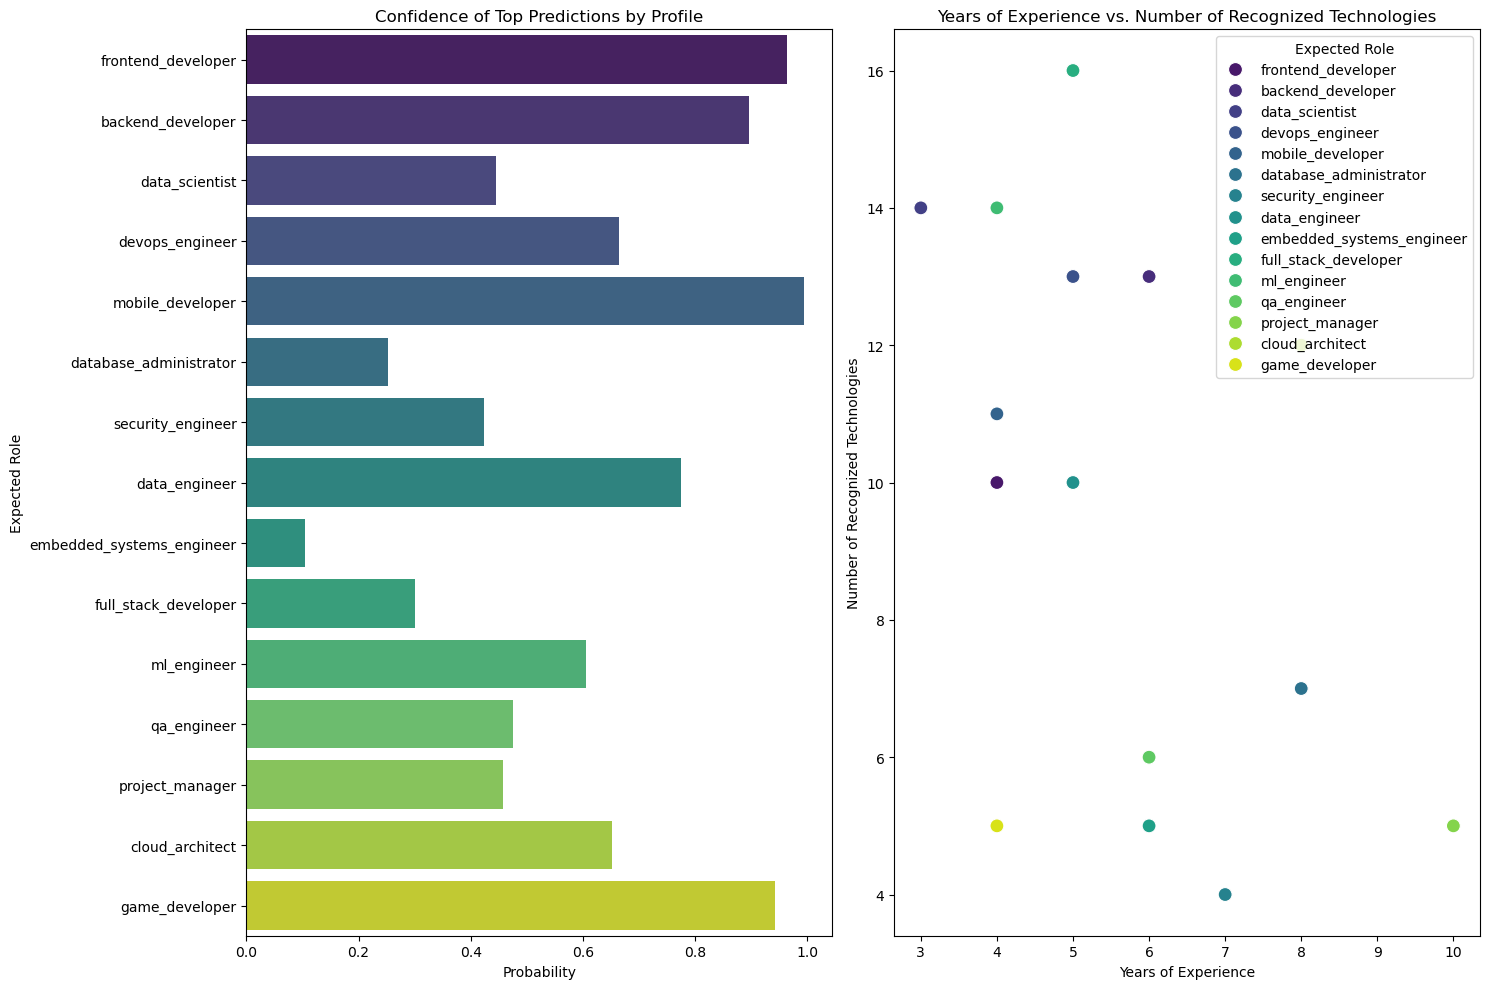

AttributeError: 'Pandas' object has no attribute 'Expected_Role'

In [ ]:
# Visualize test results
def visualize_test_results(results):
    """Visualize the test results using bar charts."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Create a DataFrame for easier visualization
    visualization_data = []
    
    for role_name, result in results.items():
        # Get the top prediction
        top_prediction = result['predictions'][0]['career_path']
        top_probability = result['predictions'][0]['probability']
        
        visualization_data.append({
            'Expected Role': role_name,
            'Top Prediction': top_prediction,
            'Probability': top_probability,
            'Years Experience': result['years_experience'],
            'Technologies Count': len(result['recognized_techs'])
        })
    
    df = pd.DataFrame(visualization_data)
    
    # Create a bar plot with the top predictions and their probabilities
    plt.subplot(1, 2, 1)
    sns.barplot(x='Probability', y='Expected Role', data=df, palette='viridis')
    plt.title('Confidence of Top Predictions by Profile')
    plt.xlabel('Probability')
    plt.ylabel('Expected Role')
    
    # Create a scatter plot of years experience vs. technologies count
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Years Experience', y='Technologies Count', 
                   data=df, s=100, hue='Expected Role', palette='viridis')
    plt.title('Years of Experience vs. Number of Recognized Technologies')
    plt.xlabel('Years of Experience')
    plt.ylabel('Number of Recognized Technologies')
    
    plt.tight_layout()
    plt.show()
    
    # Print matching statistics
    exact_matches = sum(1 for row in df.itertuples() if row.Expected_Role.replace('_', ' ') in row.Top_Prediction.lower())
    print(f"Exact or partial role matches: {exact_matches} out of {len(df)} ({exact_matches/len(df)*100:.1f}%)")

# Uncomment to visualize test results
if 'test_results' in locals():
    visualize_test_results(test_results)
else:
    print("Run the test_all_samples function first to generate results")